In [26]:
%load_ext autoreload
%autoreload 2

import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval, Params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
with open('/home/kuntik/dev/datasets/dental_rtg_merged2/annotations.json', 'r') as f:
    ann_file = json.load(f)
with open('rtg2_preds_effdet.json', 'r') as f:
    pred_file = json.load(f)

In [29]:
all_preds = []
pred_id = 0
train = []
val = []
for image in ann_file['images']:
    id = image['id']
    pred = pred_file[image['file_name']]
    # for pred in pred_file[image['file_name']]:
    for (bbox, score, label) in zip(pred['bboxes'], pred['scores'], pred['labels']):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        final_box = [x1,y1, width, height]
        area = width * height
        pred_dict = {'area' : area, 'id' : pred_id, 'bbox' : final_box, 'image_id' : id, 'category_id' : 1, 'score' : score}
        all_preds.append(pred_dict)
        pred_id += 1
    if pred['stage'] == 'valid':
        val.append(id)
    else:
        train.append(id)

data = {'categories' : [{'supercategory' : "", 'name' : 'decay', 'id' : 1}]}
data['images'] = ann_file['images']
data['annotations'] = all_preds
train_val = {'type' : 'id', 'train' : train, 'val' : val}


with open('rtg2_effdet.json', 'w') as fp:
    json.dump(data['annotations'], fp)

In [30]:
from prediction_evaluation import PredictionEval
dataDir = '/home/kuntik/dev/datasets/dental_merged'
annFile = '/home/kuntik/dev/datasets/dental_rtg_merged2/annotations.json'
resFile = 'rtg2_effdet.json'
with open('train_val_names.json', 'r') as f:
    train_val_names = json.load(f)
pred_eval = PredictionEval()
pred_eval.load_data_coco_files(annFile, resFile, train_val_names)
queries = pred_eval.default_queries()
# pred_eval.cocoEval.evaluate()
# pred_eval.evaluate_map(queries, stage='val', summary=True)
text = pred_eval.get_latex_table()
print(text)

# pred_eval.

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.64s)
creating index...
index created!
Running per image evaluation...
DONE (t=2.86s).
Accumulating evaluation results...
DONE (t=0.59s).
 Average Precision  (AP) @[ IoU=0.05:0.95 | area=   all | maxDets=100 ] = 0.168
0.1683779924455489
 Average Precision  (AP) @[ IoU=0.05:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.30      | area=   all | maxDets=100 ] = 0.666
0.6659947396917841
 Average Precision  (AP) @[ IoU=0.30      | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
0.524906719069937
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
0.04078025471065879
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (

In [31]:
print(text)

stage  & AP & AP@.3 & AP@.5 & AP@.75 & AP@.5_S & AP@.5_M & AP@.5_L \ \hline
        training & 0.297& 0.82 & 0.735 & 0.164 
        & 0.552 & 0.838 & 0.815
        validation & 0.168& 0.666 & 0.525 & 0.041 
        & 0.435 & 0.606 & 0.527
        


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def set_size(width_pt, fraction=1, subplots=(1,1)):
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    return (fig_width_in, fig_height_in)

plt.style.use('seaborn')
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "arial",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}
plt.rcParams.update(tex_fonts)

In [6]:
all_precision = pred_eval.cocoEval.eval['precision']

pr_15 = all_precision[2, :, 0, 0, 2] # data for IoU@0.5
pr_25 = all_precision[2, :, 0, 0, 2] # data for IoU@0.5
pr_40 = all_precision[7, :, 0, 0, 2] # data for IoU@0.7
pr_50 = all_precision[9, :, 0, 0, 2] # data for IoU@0.9
pr_60 = all_precision[11, :, 0, 0, 2] # data for IoU@0.9
pr_70 = all_precision[13, :, 0, 0, 2] # data for IoU@0.9

x = np.arange(0, 1.01, 0.01)
fig, ax = plt.subplots(1,1, figsize=set_size(407))
ax.plot(x, pr_25, label='IoU@0.25')
ax.plot(x, pr_40, label='IoU@0.4')
ax.plot(x, pr_50, label='IoU@0.5')
ax.plot(x, pr_60, label='IoU@0.6')
ax.plot(x, pr_70, label='IoU@0.7')
ax.legend()

ax.set_xlabel('recall')
ax.set_ylabel('precision')
fig.savefig('iou_val_multiple.pdf', format='pdf', bbox_inches='tight')

plt.show()

NameError: name 'pred_eval' is not defined

In [33]:
queries = [{"ap" : 1, "iouThr": round(i*0.05,4), "areaRng":'all', 'maxDets': 100} for i in range(1,20)]
maps_val = pred_eval.evaluate_map(queries, stage='val')
maps_train = pred_eval.evaluate_map(queries, stage='train')
iouThr = [0.05 * i for i in range(1,20)]


Running per image evaluation...
DONE (t=1.25s).
Accumulating evaluation results...
DONE (t=0.28s).
 Average Precision  (AP) @[ IoU=0.05      | area=   all | maxDets=100 ] = 0.764
0.7644460514733482
 Average Precision  (AP) @[ IoU=0.05      | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.760
0.760347660902615
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.15      | area=   all | maxDets=100 ] = 0.756
0.7560131436688008
 Average Precision  (AP) @[ IoU=0.15      | area=   all | maxDets=100 ] = 0.756
 Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = 0.750
0.7504067280612118
 Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.742
0.7419627328653737
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.742
 Averag

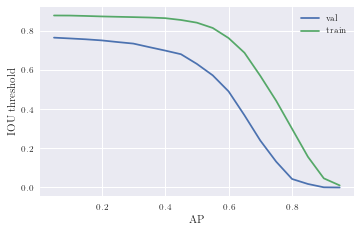

In [34]:
fig, ax = plt.subplots(1,1, figsize=set_size(407))
ax.plot(iouThr, maps_val, label='val')
ax.plot(iouThr, maps_train, label='train')
ax.legend()
ax.set_xlabel('AP')
ax.set_ylabel('IOU threshold')
fig.savefig('iou_threshold.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [25]:
with open('predictions2.json', 'w') as fp:
    json.dump(data['annotations'], fp)

In [19]:
annType = ['bbox']
prefix = 'instances'
dataDir = '/home/kuntik/dev/datasets/dental_merged'
annFile = '/home/kuntik/dev/datasets/dental_rtg_merged2/annotations.json'
cocoGt = COCO(annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
